In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os 
import sys
sys.path.append(os.path.abspath('../..'))

# Merging PV Values and Weather Data together

In [128]:
def preprocess_weather(df):
    """ 
    Scales the weather data and extracts the relevant time interval.
    Keeps only neccessary columns.
    """
     # Convert the column to datetime format
    df["validdate"] = pd.to_datetime(df["validdate"])
    df['datetime'] = df['validdate'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # Extract the date and time components into separate columns
    df["time"] = df["validdate"].dt.strftime("%H:%M")
    # keep only values where time is between 08:00 and 16:00
    df = df[(df['time'] >= '08:00') & (df['time'] <= '16:00')]
    df = df.drop(columns=['validdate', 'time'], axis=1)

    # standardise the data
    for col in df.columns:
        if col in ['datetime', 'lat', 'lon']:
            continue

        df[col] = (df[col]  - df[col].min())/ (df[col].max() - df[col].min())

    return df

def load_weather_data():
    # get path to directory
    current_directory = os.getcwd().split("Dissertation")[0] + 'pv_data/weather_data'
    # get list of files in directory
    files = os.listdir(current_directory)
    # remove DS_Store file
    files.pop(0)
    # sort files
    files.sort()

    df_dict = {}
    for file in files:
        path_to_file = os.path.join(current_directory, file)
        df = pd.read_csv(path_to_file, sep=';')
        df = preprocess_weather(df)
        df_dict[file] = df
    
    return df_dict    

In [129]:
df_dict = load_weather_data()

In [130]:
df_list = [df for df in df_dict.values()]
df_weather = pd.concat(df_list, axis=0)

In [131]:
df_weather.head()

,lat,lon,t_2m:C,relative_humidity_2m:p,wind_speed_10m:ms,diffuse_rad:W,global_rad:W,effective_cloud_cover:octas,datetime
0,53.33,-2.99,0.304225,0.808659,0.222930,0.000000,0.000000,0.500,2018-01-01 08:00:00
1,53.33,-2.99,0.301408,0.835196,0.210191,0.007789,0.015471,0.750,2018-01-01 09:00:00
2,53.33,-2.99,0.329577,0.789106,0.242038,0.091372,0.041628,0.500,2018-01-01 10:00:00
3,53.33,-2.99,0.357746,0.744413,0.273885,0.072798,0.149720,0.375,2018-01-01 11:00:00
4,53.33,-2.99,0.385915,0.705307,0.305732,0.086579,0.178117,0.125,2018-01-01 12:00:00


In [132]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 365
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_SYSTEMS = 500
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [133]:
from data import PVDataGenerator
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=POLY_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='poly',
                    drop_nan=False)

==> Loading data
==> Loaded data in: 0 m : 3 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [92]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

In [93]:
df_pv = generator.pv_series
df_pv['month'] = df_pv['datetime'].dt.month
df_pv['season'] = df_pv['datetime'].dt.month.apply(lambda x: get_season(x))
df_pv = df_pv.drop(['epoch', 'farm'], axis=1)

In [251]:
import numpy as np
def merge_weather_and_pv(df_weather, df_pv,):
    # Convert 'datetime' columns to datetime type if not already done
    df_pv['datetime'] = pd.to_datetime(df_pv['datetime'])
    df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

    # get the data in df_pv that has the latitude longitude pairs from unique_coords
    unique_coords = df_weather[['lat', 'lon']].drop_duplicates()
    merged_dataframes = []

    for index, row in unique_coords.iterrows():
        lat, lon = row['lat'], row['lon']
        pv_test = df_pv[(df_pv['latitude'] == lat) & (df_pv['longitude'] == lon)]
        weather_test = df_weather[(df_weather['lat'] == lat) & (df_weather['lon'] == lon)]
        weather_test = weather_test.drop(['lat', 'lon'], axis=1)

        merged_df = pv_test.merge(weather_test, how='outer', on='datetime')
        # set index to datetime
        
        # interpolate nan values
        for col in merged_df.columns:
            if col in ['latitude', 'longitude', 'season']:
                continue
            
            if merged_df[col].isnull().values.any():
                merged_df[col] = merged_df[col].interpolate(method='linear', limit_direction='both')
        merged_dataframes.append(merged_df)
    # concatenate all the merged data frames into a single data frame
    final_merged_df = pd.concat(merged_dataframes, ignore_index=True)
    
    return final_merged_df



In [253]:
df = merge_weather_and_pv(df_weather=df_weather, df_pv=df_pv)
df.head()

,datetime,PV,latitude,longitude,month,season,t_2m:C,relative_humidity_2m:p,wind_speed_10m:ms,diffuse_rad:W,global_rad:W,effective_cloud_cover:octas
0,2018-01-01 08:00:00,0.0,53.33,-2.99,1.0,winter,0.304225,0.808659,0.222930,0.000000,0.000000,0.500000
1,2018-01-01 08:05:00,0.0,53.33,-2.99,1.0,winter,0.303991,0.810871,0.221868,0.000649,0.001289,0.520833
2,2018-01-01 08:10:00,0.0,53.33,-2.99,1.0,winter,0.303756,0.813082,0.220807,0.001298,0.002578,0.541667
3,2018-01-01 08:15:00,0.0,53.33,-2.99,1.0,winter,0.303521,0.815293,0.219745,0.001947,0.003868,0.562500
4,2018-01-01 08:20:00,0.0,53.33,-2.99,1.0,winter,0.303286,0.817505,0.218684,0.002596,0.005157,0.583333


In [256]:
from data.utils import save_csv
save_csv(df, folder_name='pv_data', file_name='pv_and_weather.csv')
unique_lat_lon = df[['latitude', 'longitude']].drop_duplicates()
save_csv(unique_lat_lon, folder_name='pv_data', file_name='location_data_weather_clean.csv')

In [2]:
# data parameters
DAY_INIT = 40
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 7
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_SYSTEMS = 10
# create a tuple of 4 coordinates that form a polygon in the uk
# and a circle with a radius of r
CIRCLE_COORDS = (53.5, -3)
RADIUS = 0.4
POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))


In [3]:
from data import PVWeatherLoader

loader = PVWeatherLoader(
    # number of days to get data for
    n_days=N_DAYS,
    # initial day of the data for that season
    # look at the data frame to see which day it is
    day_init=DAY_INIT,
    # number of systems to extract
    n_systems=N_SYSTEMS,
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    # the minute interval our data is sampled at 
    # (e.g. 60 for hourly, 30 for half hourly, 15 for 15 minutes, etc.)
    minute_interval=MINUTE_INTERVAL,
    # the minimum and maximum hour of the day to use
    # (e.g. 8 and 15 for 8am to 3pm)
    day_min=DAY_MIN,
    day_max=DAY_MAX,
    folder_name='pv_data',
    file_name='pv_and_weather.csv',
    distance_method='circle',
    # optionally use a season
    season='winter',
    # optionally drop series with nan values
    drop_nan=False
)

==> Loading data
==> Loaded data in: 0 m : 9 sec

Number of unique lat lon pairs: 12


# Examples of using the Weather Loader

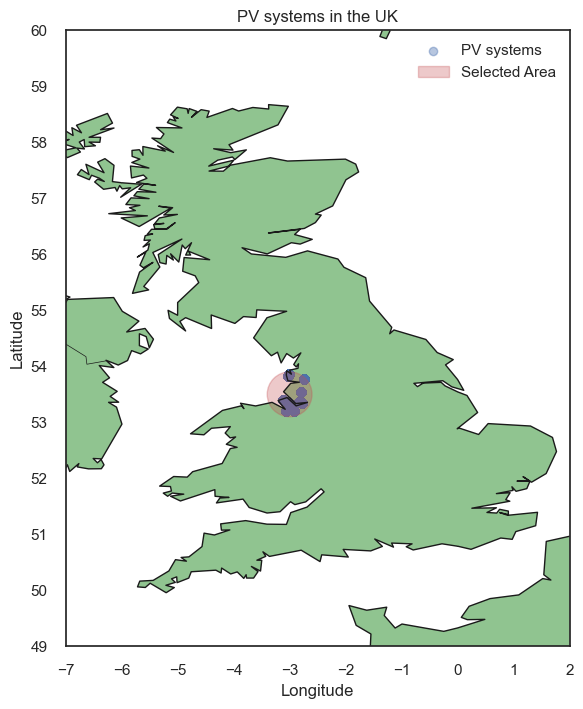

In [259]:
# getting the dataframe
from pv_plot import plot_grid
loader.df
plot_grid(loader.df, coords=CIRCLE_COORDS, radius=RADIUS, distance_method='circle')

In [4]:
X, _ = next(iter(loader))
d = X.shape[1]

In [5]:
import torch
from kernels import get_mean_covar_weather
from models import ApproximateGPBaseModel
from likelihoods import BetaLikelihood_MeanParametrization

mean, covar = get_mean_covar_weather(num_latents=1,
                                     d=d,
                                     combine='sum')
likelihood = BetaLikelihood_MeanParametrization(scale=30)


In [7]:
jitter = 1e-4
config = {
    'type' : 'stochastic',
    'name' : 'cholesky',
    'jitter' : jitter,
}
inputs ={
    'mean_module' : mean,
    'covar_module': covar,
    'likelihood': likelihood,
    'learn_inducing_locations': False,
    'jitter': jitter,
}

Iter 20/200 - Loss: 0.797
Iter 40/200 - Loss: 0.001
Iter 60/200 - Loss: -0.255
Iter 80/200 - Loss: -0.364
Iter 100/200 - Loss: -0.456
Iter 120/200 - Loss: -0.545
Iter 140/200 - Loss: -0.633
Iter 160/200 - Loss: -0.719
Iter 180/200 - Loss: -0.800
Iter 200/200 - Loss: -0.876
Iter 20/200 - Loss: -0.215
Iter 40/200 - Loss: -1.060
Iter 60/200 - Loss: -1.107
Iter 80/200 - Loss: -1.145
Iter 100/200 - Loss: -1.165
Iter 120/200 - Loss: -1.180
Iter 140/200 - Loss: -1.191
Iter 160/200 - Loss: -1.198
Iter 180/200 - Loss: -1.203
Iter 200/200 - Loss: -1.205
Iter 20/200 - Loss: -1.065
Iter 40/200 - Loss: -1.305
Iter 60/200 - Loss: -1.334
Iter 80/200 - Loss: -1.347
Iter 100/200 - Loss: -1.351
Iter 120/200 - Loss: -1.353
Iter 140/200 - Loss: -1.354
Iter 160/200 - Loss: -1.354
Iter 180/200 - Loss: -1.354
Iter 200/200 - Loss: -1.354
Iter 20/200 - Loss: -0.979
Iter 40/200 - Loss: -1.132
Iter 60/200 - Loss: -1.164
Iter 80/200 - Loss: -1.173
Iter 100/200 - Loss: -1.175
Iter 120/200 - Loss: -1.176
Iter 140/2

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

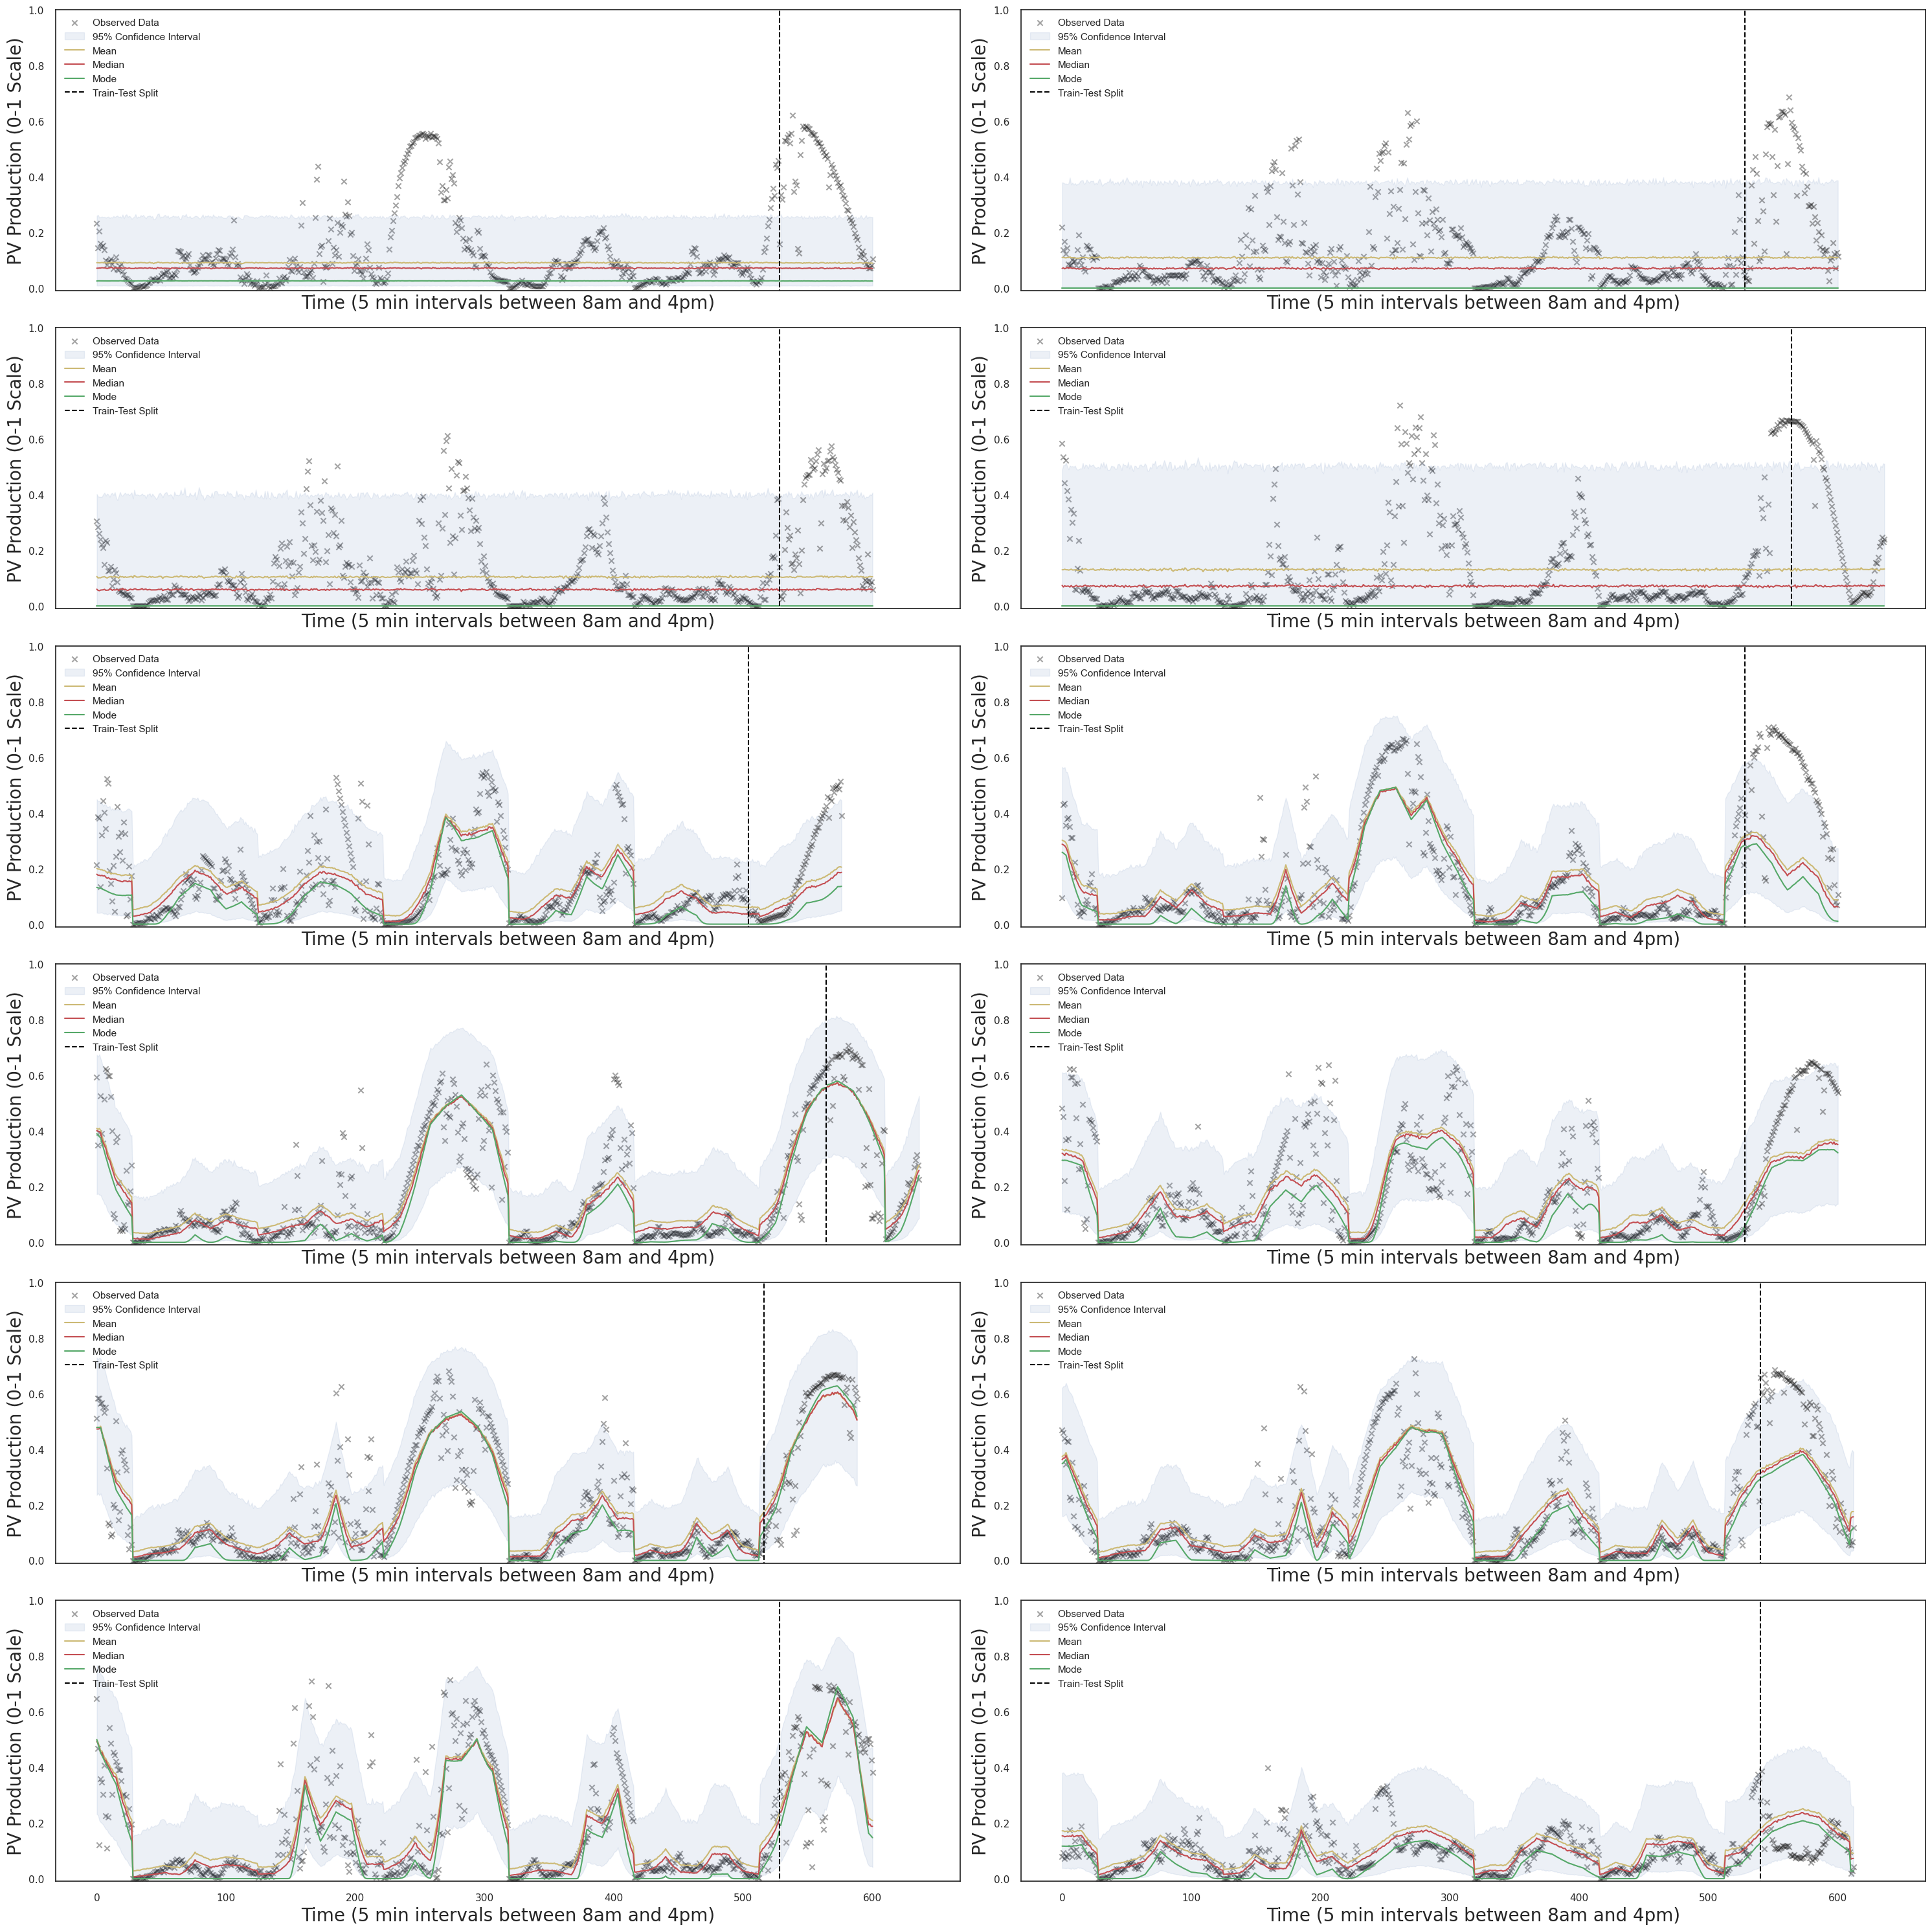

In [8]:
from data.utils import train_test_split
from pv_plot import plot_gp_ax

fig, axs = plt.subplots(len(loader) // 2, 2, figsize=(30, 30), sharex=True)
axs = axs.flatten()
plt.rcParams['font.family'] = 'Arial'

for i, (X, y) in enumerate(loader):
    
    hour = np.random.randint(8, 14)
    x_train, y_train, x_test, y_test = train_test_split(X, y, hour,minute_interval=5, day_min=8, day_max=16,  n_hours=6)
    n_tr = x_train.size(0)
    n_te = x_test.size(0)
    t = torch.linspace(0, 100, n_tr + n_te).unsqueeze(-1)
    t_train = t[:n_tr]
    t_test = t[n_tr:n_tr + n_te]
    x_train = torch.cat([x_train, t_train], dim=-1)
    x_test = torch.cat([x_test, t_test], dim=-1)
    config['num_inducing_points'] = x_train.size(0)
    inputs['config'] = config
    inputs['X'] = x_train
    inputs['y'] = y_train

    model = ApproximateGPBaseModel(**inputs)
    model.fit(n_iter=200, lr=0.2, verbose=True)
    plot_gp_ax(model, x_train, x_test, y_train, y_test, pred_type='all', ax=axs[i])

plt.tight_layout();